In [2]:
import os
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders
from tqdm import tqdm
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

> Not use : year wise token count

# space used by each year's paper

## difference between the previous version (DATA) and the current version (DATA_2) 
previous version has some problem related to begin{document} ... end{document} extraction

In [3]:
# plot the size of each folder in the directory
root_dir = "/mnt/NFS/patidarritesh/SID_DATA_PROCESSED/DATA"


lst_old = []
for yr in range(24):
# for dir in os.listdir(root_dir+f"20{year}/preprocessing_1"):
    # run following command using os.subprocess to get the size of each folder
    # du -hs /mnt/NFS/patidarritesh/PDF_2_TEX/2023/preprocessing_1/2301
    # year_ = f"0{yr}" if yr < 10 else f"{yr}"    
    size = subprocess.run(["du", "-s", root_dir+f"/{yr}/"], capture_output=True)
    size = size.stdout.decode('utf-8').split("\t")[0]
    lst_old.append([yr, size])
lst_old

[[0, '1465956'],
 [1, '1503712'],
 [2, '1657448'],
 [3, '1837664'],
 [4, '2084244'],
 [5, '2218912'],
 [6, '2464732'],
 [7, '2741304'],
 [8, '3004840'],
 [9, '3378272'],
 [10, '3817744'],
 [11, '4748828'],
 [12, '4936552'],
 [13, '5434532'],
 [14, '6079932'],
 [15, '6808440'],
 [16, '7565468'],
 [17, '8261444'],
 [18, '9598280'],
 [19, '10976720'],
 [20, '13364128'],
 [21, '14190764'],
 [22, '14800232'],
 [23, '11143260']]

In [4]:
# plot the size of each folder in the directory
root_dir = "/mnt/NFS/patidarritesh/SID_DATA_PROCESSED/DATA_2"
import os
import subprocess


lst_new = []
for yr in range(24):
# for dir in os.listdir(root_dir+f"20{year}/preprocessing_1"):
    # run following command using os.subprocess to get the size of each folder
    # du -hs /mnt/NFS/patidarritesh/PDF_2_TEX/2023/preprocessing_1/2301
    # year_ = f"0{yr}" if yr < 10 else f"{yr}"    
    size = subprocess.run(["du",'-s', root_dir+f"/{yr}/"], capture_output=True)
    size = size.stdout.decode('utf-8').split("\t")[0]
    lst_new.append([yr, size])
lst_new

[[0, '1491972'],
 [1, '1531784'],
 [2, '1690612'],
 [3, '1873544'],
 [4, '2127064'],
 [5, '2264156'],
 [6, '2515888'],
 [7, '2800796'],
 [8, '3068840'],
 [9, '3451228'],
 [10, '3898920'],
 [11, '4844424'],
 [12, '5042640'],
 [13, '5556112'],
 [14, '6217204'],
 [15, '6966876'],
 [16, '7739976'],
 [17, '8444932'],
 [18, '9810268'],
 [19, '11216676'],
 [20, '13645452'],
 [21, '14491720'],
 [22, '15107484'],
 [23, '11407044']]

In [5]:
summ = 0
for i in range(24):
    diff = (int(lst_new[i][1]) - int(lst_old[i][1]))
    summ += diff

print(f"Total prev size {sum([int(i[1]) for i in lst_old])/10**6:.2f} GB")
print(f"Total new size {sum([int(i[1]) for i in lst_new])/10**6:.2f} GB")
print(f"Total diff {summ/10**6:.2f} GB")
print(f"ratio new/old {sum([int(i[1]) for i in lst_new])/sum([int(i[1]) for i in lst_old]):.2f}")


Total prev size 144.08 GB
Total new size 147.21 GB
Total diff 3.12 GB
ratio new/old 1.02


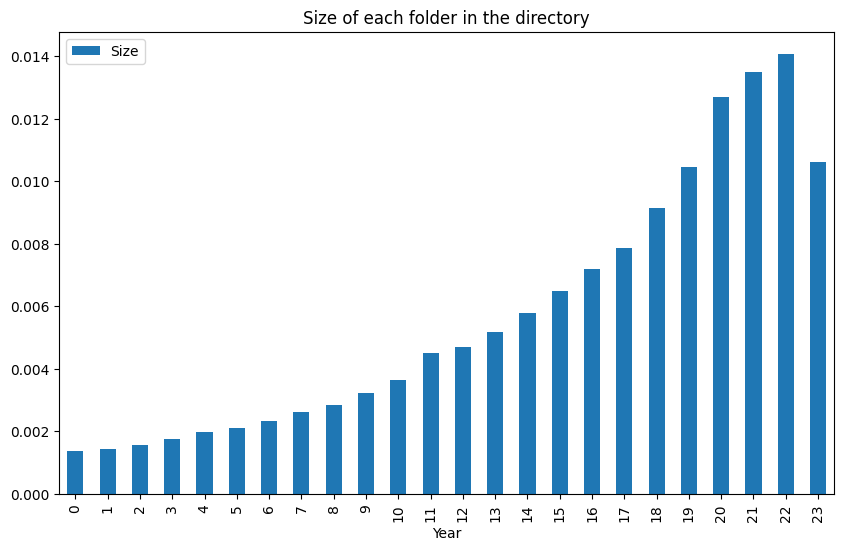

In [6]:
# plot the size of each folder in the directory
df = pd.DataFrame(lst_new, columns=["Year", "Size"])
df["Size"] = df["Size"].str.replace("G", "")
df["Size"] = df["Size"].astype(float)
df["Size"] = df["Size"]/2**30
df.plot(x="Year", y="Size", kind="bar", figsize=(10, 6), title="Size of each folder in the directory")
plt.show()


# Tokens per paper statistics


In [216]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def get_df(year=None):
    if year is None:
        df = pd.DataFrame(columns=['Year', 'Token Count'],  dtype=np.int64)
        for i in range(24):
            i_ = f"0{i}" if i < 10 else f"{i}"
            df_ = pd.read_csv(f"processed_data_level_2/tc_{i_}.csv", usecols=['Year', 'Token Count'])
            df = pd.concat([df, df_], ignore_index=True)
    else:
        if year < 10:
            year = f"0{year}"
        df = pd.read_csv(f"processed_data_level_2/tc_{year}.csv", usecols=['Year', 'Token Count'])
    return df


# # read only year and token count from csv file

# # Initialize an empty DataFrame
# df = pd.DataFrame(columns=['Year', 'Token Count'], dtype=np.float64)
# # Loop through the range and concatenate DataFrames
# for i in range(24):
#     i_ = f"0{i}" if i < 10 else f"{i}"
#     df_ = pd.read_csv(f"processed_data_level_2/tc_{i_}.csv", usecols=['Year', 'Token Count'])
#     df = pd.concat([df, df_], ignore_index=True)

# # Display the resulting DataFrame


df = get_df()
df.describe()



,Year,Token Count
count,1.986599e+06,1.986599e+06
mean,1.503454e+03,1.640423e+04
std,6.293746e+02,5.502389e+04
min,1.000000e+00,1.300000e+01
25%,1.102000e+03,6.710000e+03
50%,1.612000e+03,1.173600e+04
75%,2.010000e+03,2.000300e+04
max,2.308000e+03,6.414872e+07


## Experiments and results

In [217]:
def min_max_percentile_crop(df, col, min_percentile=0.1, max_percentile=0.8):
    return df[(df[col] < df[col].quantile(max_percentile)) & (df[col] > df[col].quantile(min_percentile))]

def token_distribution_plot1(df, df4,  min_percentile, max_percentile, col='Token Count', num_bins=10):    
    # increase the size of the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
    # plot 1
    token_range_counts = pd.cut(df[col], bins=num_bins).value_counts(sort=False)
    # log scale
    token_range_counts = token_range_counts.apply(lambda x: np.log(x + 1))

    for i, (bar, count, label) in enumerate(zip(ax1.bar(token_range_counts.index.astype(str), token_range_counts.values), token_range_counts.values, token_range_counts.index.astype(str))):
        # set alternate colors for bars 
        if i % 2 == 0:
            bar.set_color('r')
        else:
            bar.set_color('g')
        # height = bar.get_height()
        # label_y = height / 2
        # ax1.text(bar.get_x() + bar.get_width() / 2, label_y, f'{label}', ha='center', va='center', rotation=90, color='black', fontsize=8)
    
    ax1.tick_params(axis='x', rotation=90)
    # ax1.set_xticks([]) # to hide xticks
    # ax1.set_xlabel('Token Range')
    ax1.set_ylabel('Number of Papers')
    ax1.set_title(f'#Papers/Token_Range - Raw data (log)')
    
    # plot 2
    token_range_counts = pd.cut(df4[col], bins=num_bins).value_counts(sort=False)
    print(f'\nToken Range   :       counts\n{token_range_counts}')
    for i, (bar, count, label) in enumerate(zip(ax2.bar(token_range_counts.index.astype(str), token_range_counts.values), token_range_counts.values, token_range_counts.index.astype(str))):
        # set alternate colors for bars 
        if i % 2 == 0:
            bar.set_color('r')
        else:
            bar.set_color('g')
        
        # height = bar.get_height()
        # label_y = height / 2
        # ax2.text(bar.get_x() + bar.get_width() / 2, label_y, f'{label}', ha='center', va='center', rotation=90, color='black', fontsize=8)
        
    # ax2.set_xticks([])
    ax2.tick_params(axis='x', rotation=90)
    # ax2.set_xlabel('Token Range')
    ax2.set_ylabel('Number of Papers')
    ax2.set_title(f'#Papers/Token_Range - {min_percentile*100}% to {max_percentile*100}% percentile')
    plt.tight_layout()    
    
    plt.show()

def token_distribution_plot2(df, df4,  min_percentile, max_percentile, col='Token Count', num_bins=10):

    # increase the size of the plot
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 10))
    # plot 3: pie chart of token count
    token_range_counts = pd.cut(df4[col], bins=num_bins).value_counts(sort=False)
    token_range_counts.plot(kind='pie', figsize=(15, 5), title=f'#Papers/Token_Range - {min_percentile*100}% to {max_percentile*100}% ', ax=ax3)

    # plot 4: histogram of token count
    df4.hist(column=col, bins=100, figsize=(20, 5), ax=ax4)
    ax4.set_title(f'Histogram of Token Count -  {min_percentile*100}% to {max_percentile*100}% ')

    plt.tight_layout()    
    plt.show()

    

def min_max_stats_plots(df, df2, col = "Token Count", min_percentile=0.1, max_percentile=0.8):

    print(f'Original Shape {df.shape}')
    print(f'Shape after cropping {df2.shape}\n')

    print(f"#papers: token count < {min_percentile} percentile {df[df[col] < df[col].quantile(min_percentile)].shape[0]}")
    print(f"#papers: token count > {max_percentile} percentile {df[df[col] > df[col].quantile(max_percentile)].shape[0]}")

    print("\nMinimum, \t Maximum, \t\t Mean, \t\t\t Median")
    print(f"{df[col].min():.2f}, \t\t {df[col].max():.2f}, \t\t {df[col].mean():.2f}, \t\t {df[col].median():.2f}")
    print(f"{df2[col].min():.2f}, \t {df2[col].max():.2f}, \t\t {df2[col].mean():.2f}, \t\t {df2[col].median():.2f}")


def my_stats(df, col = "Token Count", min_percentile=0.1, max_percentile=0.8):

    df4 = min_max_percentile_crop(df, col, min_percentile, max_percentile)
    min_max_stats_plots(df, df4, col, min_percentile, max_percentile)
    token_distribution_plot1(df,df4, min_percentile, max_percentile)
    token_distribution_plot2(df,df4, min_percentile, max_percentile)




### Exp 1 : 10 percentile to 80 percentile

Original Shape (1986599, 2)
Shape after cropping (1390521, 2)

#papers: token count < 0.1 percentile 198650
#papers: token count > 0.8 percentile 397297

Minimum, 	 Maximum, 		 Mean, 			 Median
13.00, 		 64148721.00, 		 16404.23, 		 11736.00
4107.00, 	 22765.00, 		 11433.75, 		 10602.00

Token Range   :       counts
Token Count
(4088.342, 5972.8]    210971
(5972.8, 7838.6]      210940
(7838.6, 9704.4]      188401
(9704.4, 11570.2]     170386
(11570.2, 13436.0]    146624
(13436.0, 15301.8]    125828
(15301.8, 17167.6]    106832
(17167.6, 19033.4]     90179
(19033.4, 20899.2]     76036
(20899.2, 22765.0]     64324
Name: count, dtype: int64


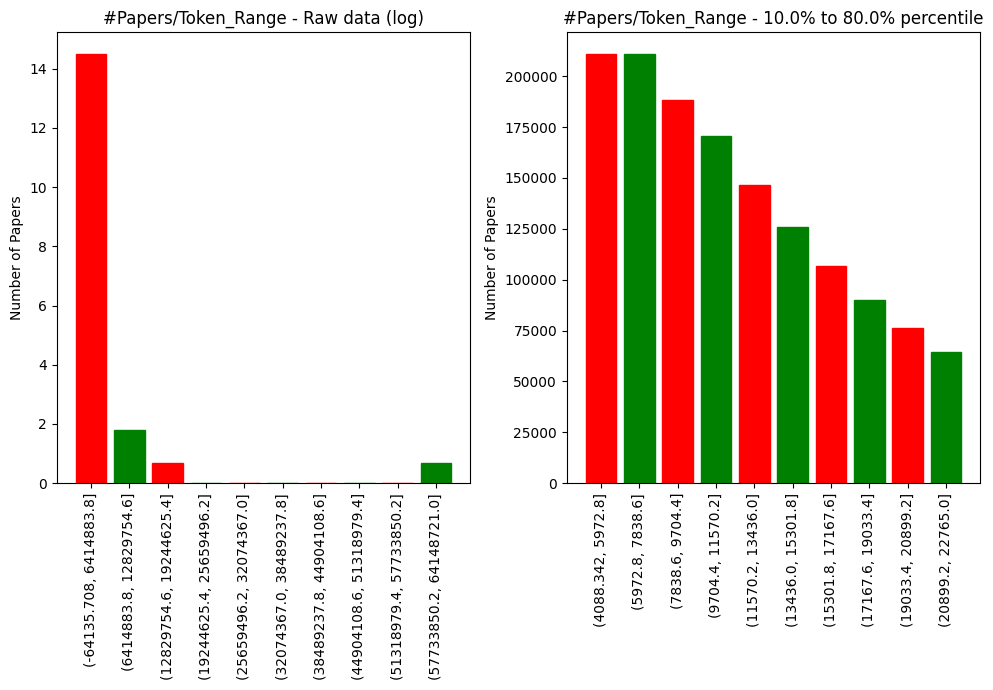

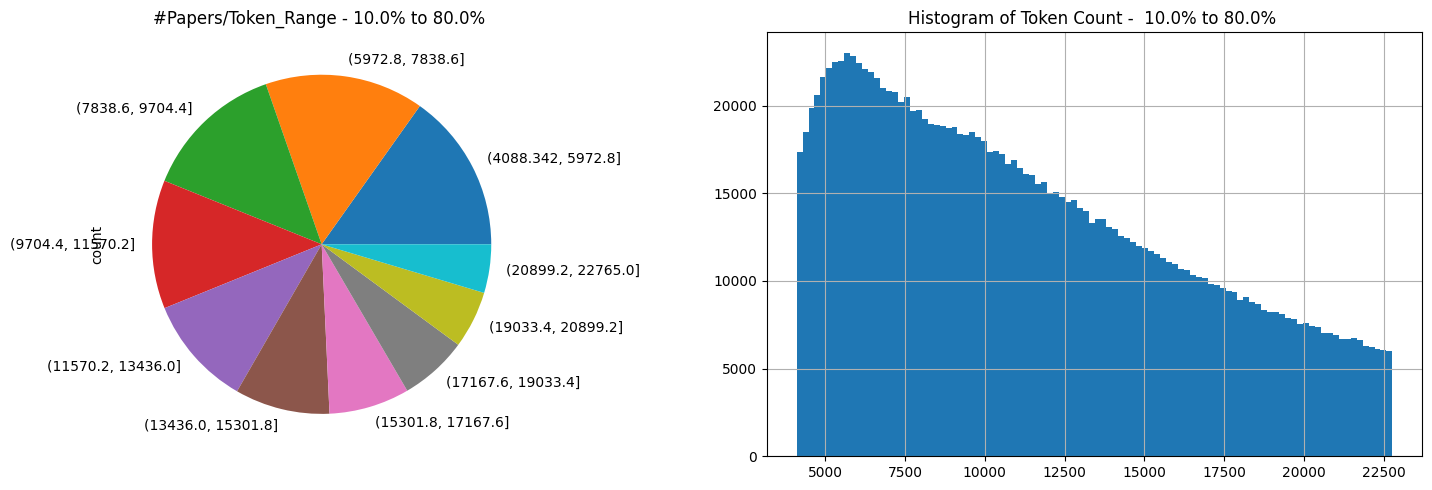

In [218]:
my_stats(df, "Token Count", min_percentile=0.1, max_percentile=0.8)

### 10 percentile to 90 percentile

Original Shape (1986599, 2)
Shape after cropping (1589199, 2)

#papers: token count < 0.1 percentile 198650
#papers: token count > 0.9 percentile 198653

Minimum, 	 Maximum, 		 Mean, 			 Median
13.00, 		 64148721.00, 		 16404.23, 		 11736.00
4107.00, 	 31974.00, 		 13349.92, 		 11737.00

Token Range   :       counts
Token Count
(4079.133, 6893.7]    318637
(6893.7, 9680.4]      289303
(9680.4, 12467.1]     245887
(12467.1, 15253.8]    196261
(15253.8, 18040.5]    154084
(18040.5, 20827.2]    119405
(20827.2, 23613.9]     92843
(23613.9, 26400.6]     71766
(26400.6, 29187.3]     56501
(29187.3, 31974.0]     44512
Name: count, dtype: int64


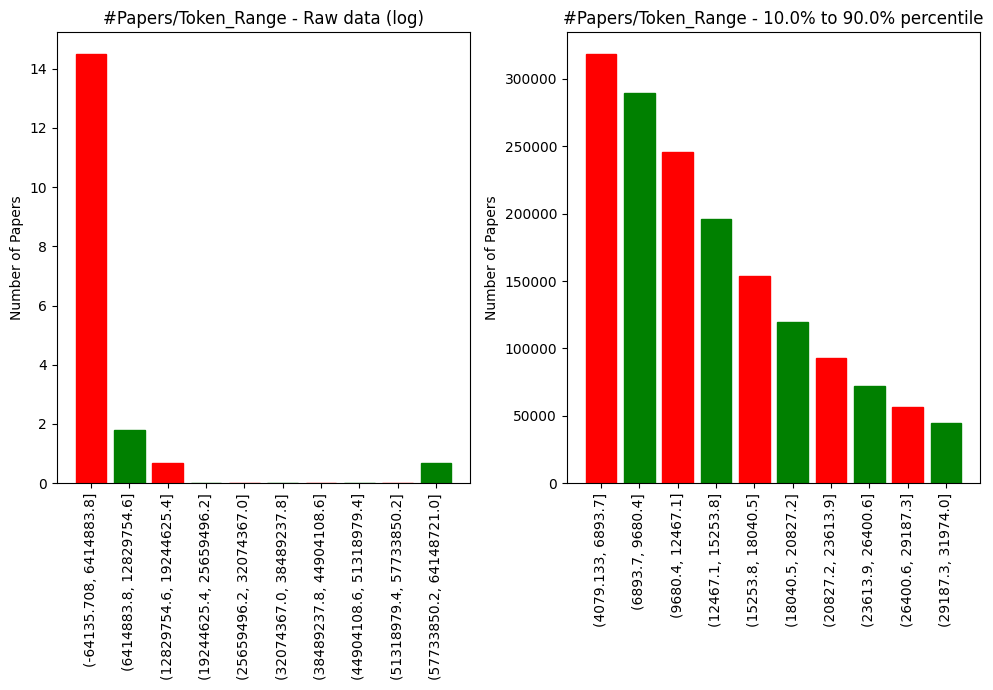

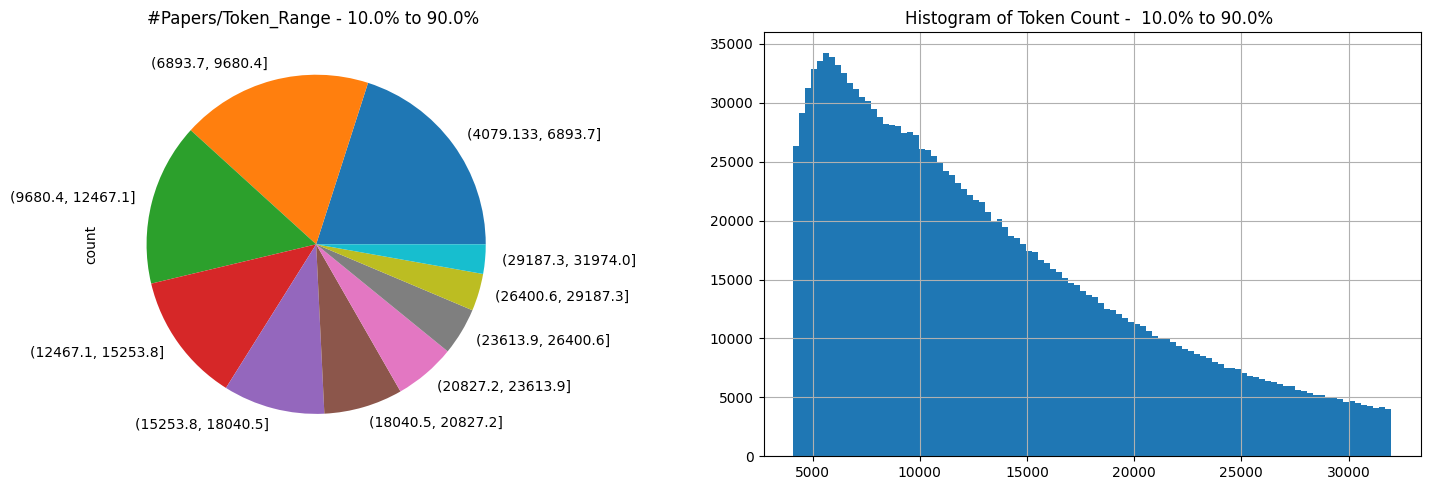

In [219]:
my_stats(df, "Token Count", min_percentile=0.1, max_percentile=0.9)

### 5 percentile to 70 percentile

Original Shape (1986599, 2)
Shape after cropping (1291220, 2)

#papers: token count < 0.05 percentile 99320
#papers: token count > 0.7 percentile 595975

Minimum, 	 Maximum, 		 Mean, 			 Median
13.00, 		 64148721.00, 		 16404.23, 		 11736.00
2530.00, 	 17789.00, 		 9483.29, 		 9056.00

Token Range   :       counts
Token Count
(2514.741, 4055.9]     95023
(4055.9, 5581.8]      167294
(5581.8, 7107.7]      179477
(7107.7, 8633.6]      161250
(8633.6, 10159.5]     150520
(10159.5, 11685.4]    136099
(11685.4, 13211.3]    120750
(13211.3, 14737.2]    106278
(14737.2, 16263.1]     93154
(16263.1, 17789.0]     81375
Name: count, dtype: int64


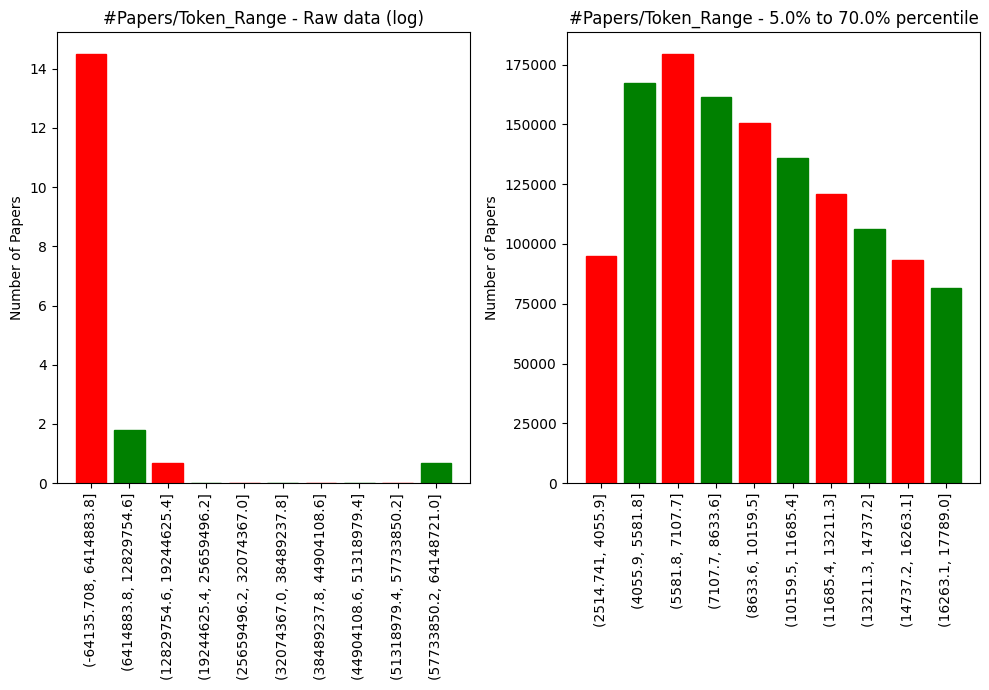

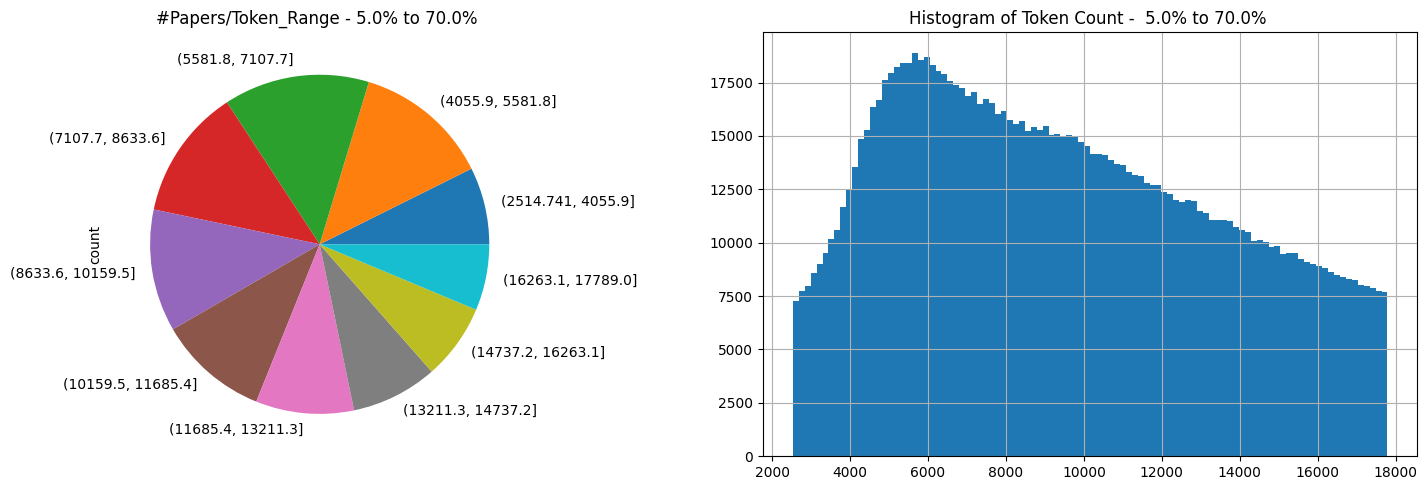

In [220]:
my_stats(df, "Token Count", min_percentile=0.05, max_percentile=0.7)

### Conclusion:

keeping 10 percentile to 90 percentile, median is not changing much


## Plot Year wise

Original Shape (31529, 2)
Shape after cropping (28155, 2)

#papers: token count < 0 percentile 0
#papers: token count > 0.9 percentile 3153

Minimum, 	 Maximum, 		 Mean, 			 Median
13.00, 		 2071269.00, 		 15065.40, 		 8463.00
17.00, 	 25406.00, 		 9311.34, 		 7650.00

Token Range   :       counts
Token Count
(-8.389, 2555.9]      1743
(2555.9, 5094.8]      5287
(5094.8, 7633.7]      7018
(7633.7, 10172.6]     4070
(10172.6, 12711.5]    2967
(12711.5, 15250.4]    2325
(15250.4, 17789.3]    1737
(17789.3, 20328.2]    1322
(20328.2, 22867.1]     964
(22867.1, 25406.0]     722
Name: count, dtype: int64


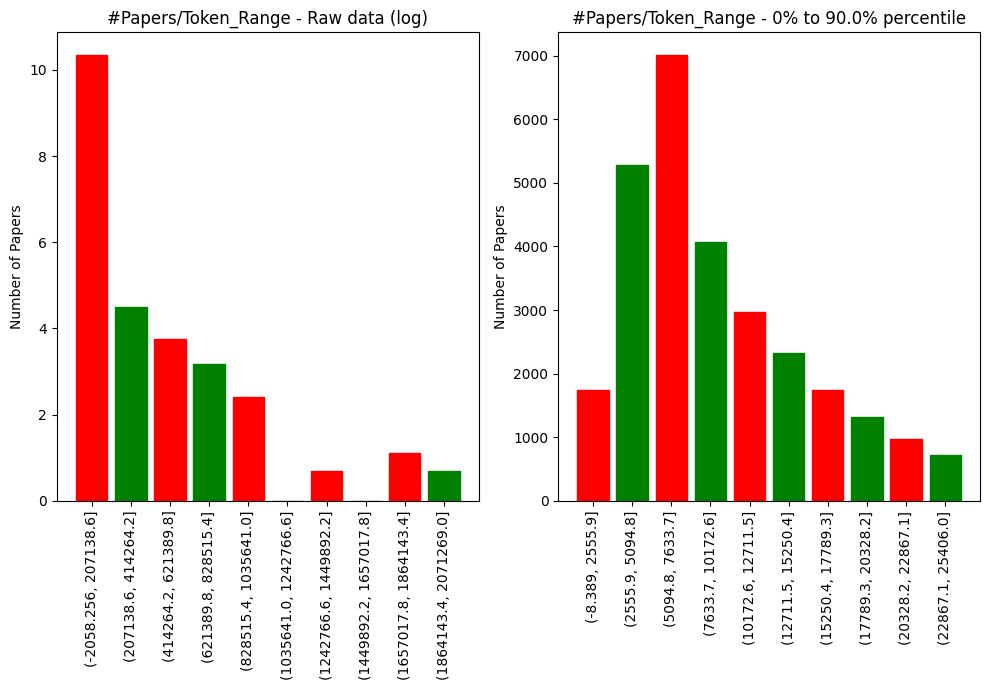

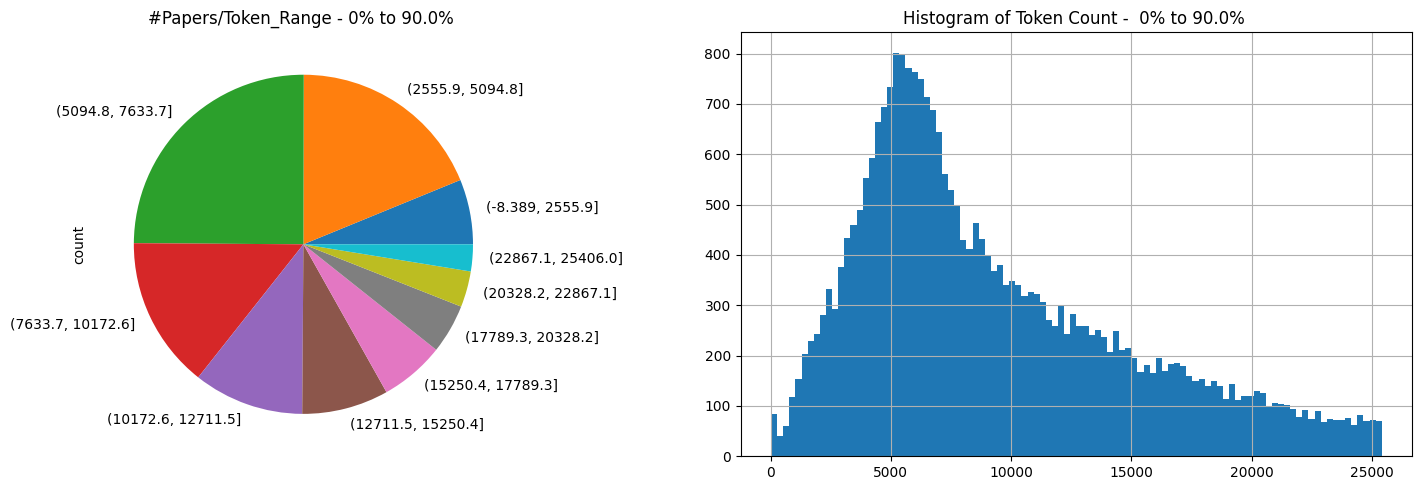

In [223]:
dfx = get_df(0)
my_stats(dfx, "Token Count", min_percentile=0, max_percentile=0.9)

Original Shape (62208, 2)
Shape after cropping (55696, 2)

#papers: token count < 0 percentile 0
#papers: token count > 0.9 percentile 6221

Minimum, 	 Maximum, 		 Mean, 			 Median
13.00, 		 2623405.00, 		 15843.33, 		 11140.50
15.00, 	 30836.00, 		 11674.74, 		 10021.00

Token Range   :       counts
Token Count
(-15.821, 3097.1]      3328
(3097.1, 6179.2]      11932
(6179.2, 9261.3]      10452
(9261.3, 12343.4]      8134
(12343.4, 15425.5]     6347
(15425.5, 18507.6]     4999
(18507.6, 21589.7]     3745
(21589.7, 24671.8]     3036
(24671.8, 27753.9]     2121
(27753.9, 30836.0]     1602
Name: count, dtype: int64


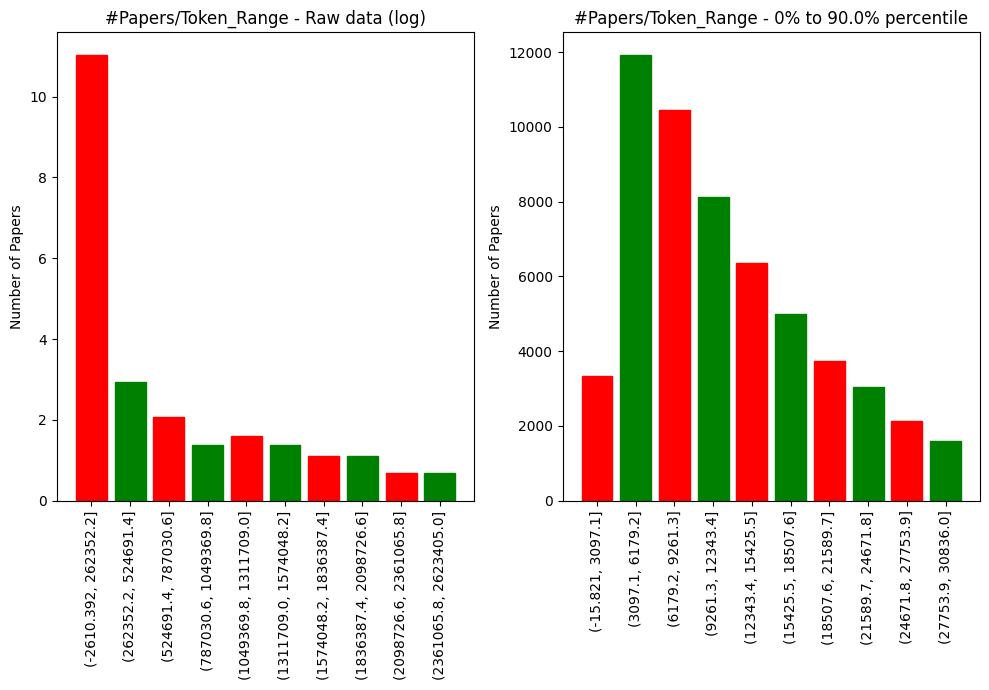

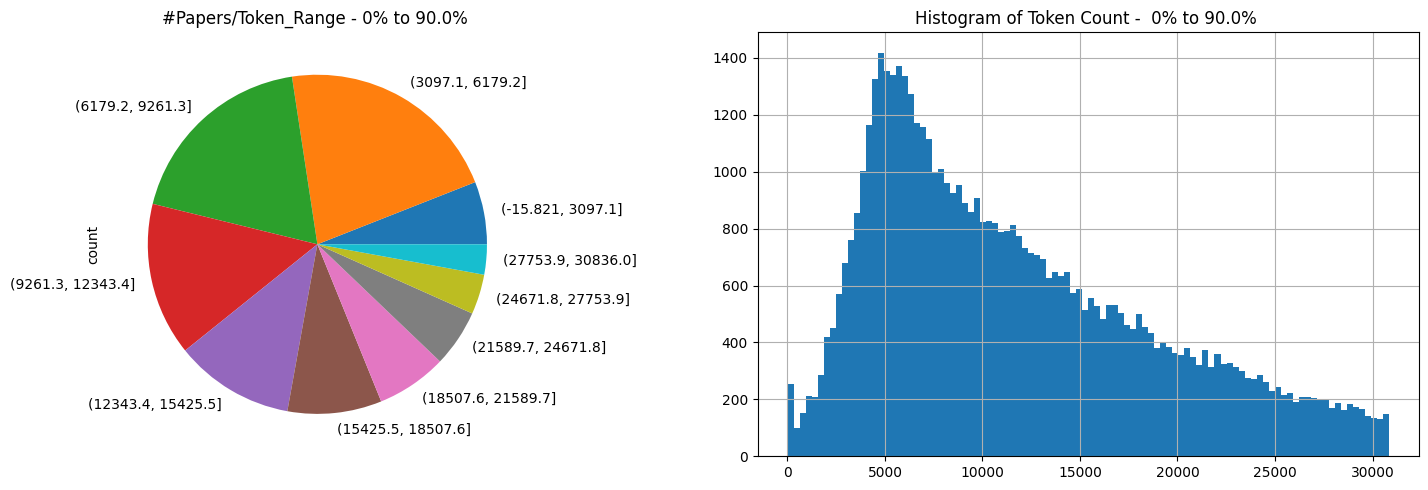

In [224]:
dfx = get_df(10)
my_stats(dfx, "Token Count", min_percentile=0, max_percentile=0.9)

Original Shape (168907, 2)
Shape after cropping (148933, 2)

#papers: token count < 0 percentile 0
#papers: token count > 0.9 percentile 16891

Minimum, 	 Maximum, 		 Mean, 			 Median
13.00, 		 2761225.00, 		 16986.88, 		 12424.00
15.00, 	 33666.00, 		 12908.88, 		 11490.00

Token Range   :       counts
Token Count
(-18.651, 3380.1]     11708
(3380.1, 6745.2]      22809
(6745.2, 10110.3]     29036
(10110.3, 13475.4]    25057
(13475.4, 16840.5]    19006
(16840.5, 20205.6]    13748
(20205.6, 23570.7]    10218
(23570.7, 26935.8]     7526
(26935.8, 30300.9]     5713
(30300.9, 33666.0]     4112
Name: count, dtype: int64


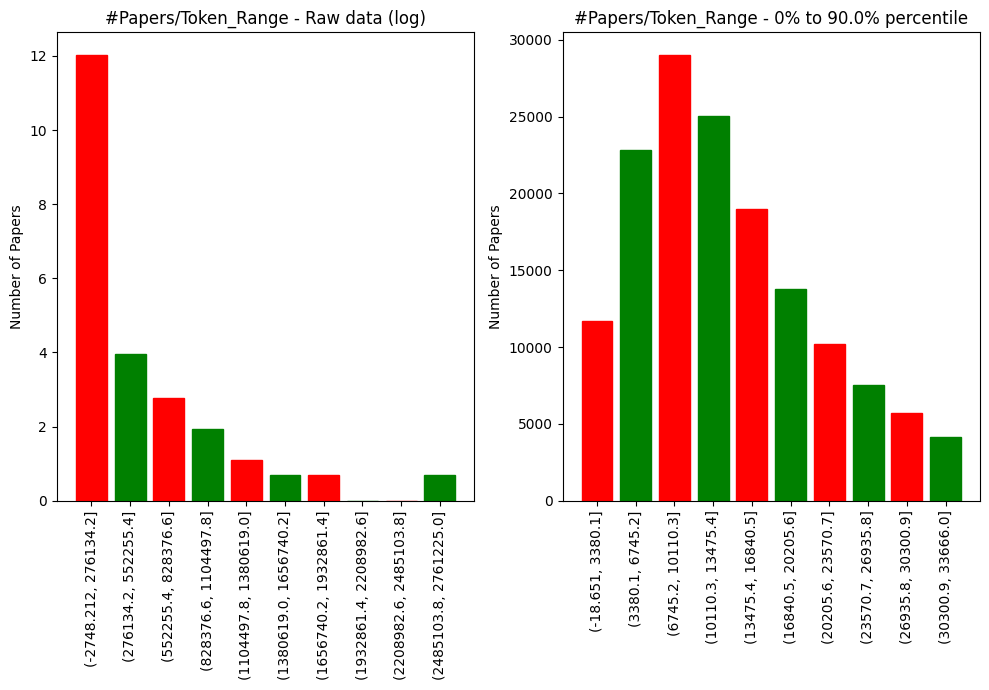

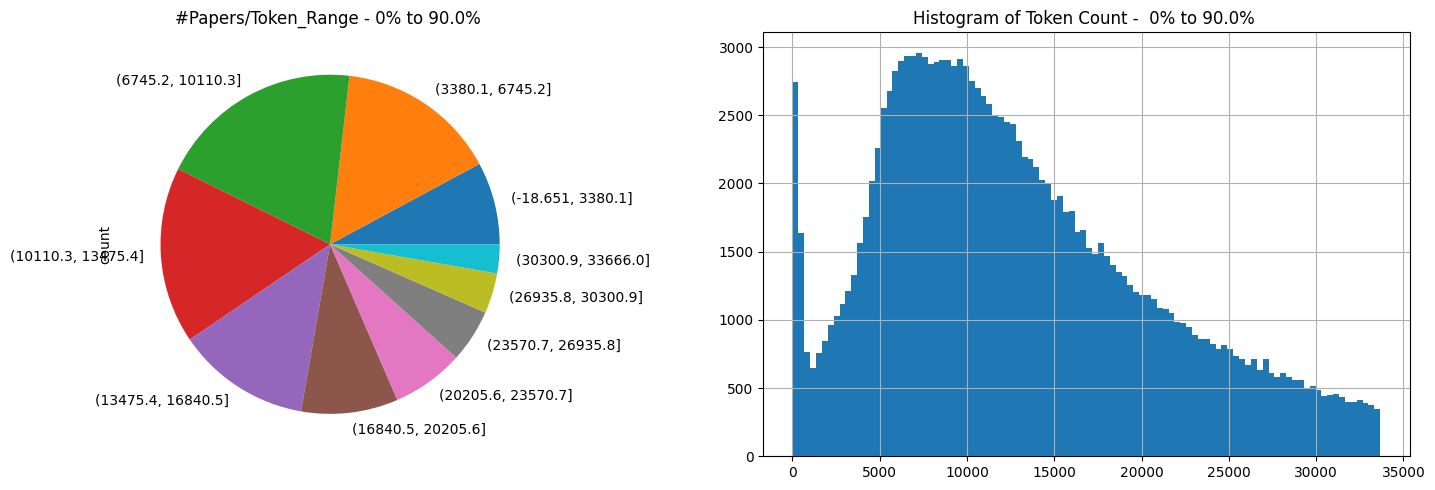

In [225]:
dfx = get_df(22)
my_stats(dfx, "Token Count", min_percentile=0, max_percentile=0.9)

# Total Token count in the corpus

In [249]:
def total_token_count(year=None):
    dfx = get_df(year)
    df2 = min_max_percentile_crop(dfx, "Token Count", 0, 1)
    count = df2["Token Count"].sum()
    print(f"{count}, {count/(10**3):.2f}K, {count/(10**6):.2f}M, {count/(10**9):.2f}B")
    return count/10**6

In [250]:
total_token_count()

32524210676, 32524210.68K, 32524.21M, 32.52B


32524.210676

In [251]:
total_token_count(0)

472922981, 472922.98K, 472.92M, 0.47B


472.922981

In [252]:
total_token_count(10)

982954796, 982954.80K, 982.95M, 0.98B


982.954796

In [253]:
total_token_count(22)

2866402478, 2866402.48K, 2866.40M, 2.87B


2866.402478

472922981, 472922.98K, 472.92M, 0.47B
422429567, 422429.57K, 422.43M, 0.42B
451934150, 451934.15K, 451.93M, 0.45B
492157814, 492157.81K, 492.16M, 0.49B
554617120, 554617.12K, 554.62M, 0.55B
581976760, 581976.76K, 581.98M, 0.58B
648213402, 648213.40K, 648.21M, 0.65B
716521861, 716521.86K, 716.52M, 0.72B
780775581, 780775.58K, 780.78M, 0.78B
877586244, 877586.24K, 877.59M, 0.88B
982954796, 982954.80K, 982.95M, 0.98B
1272308393, 1272308.39K, 1272.31M, 1.27B
1250077921, 1250077.92K, 1250.08M, 1.25B
1341536113, 1341536.11K, 1341.54M, 1.34B
1479508566, 1479508.57K, 1479.51M, 1.48B
1619052987, 1619052.99K, 1619.05M, 1.62B
1749350364, 1749350.36K, 1749.35M, 1.75B
1858304484, 1858304.48K, 1858.30M, 1.86B
2073713413, 2073713.41K, 2073.71M, 2.07B
2305830624, 2305830.62K, 2305.83M, 2.31B
2719637202, 2719637.20K, 2719.64M, 2.72B
2807441395, 2807441.40K, 2807.44M, 2.81B
2866402478, 2866402.48K, 2866.40M, 2.87B
2129341333, 2129341.33K, 2129.34M, 2.13B


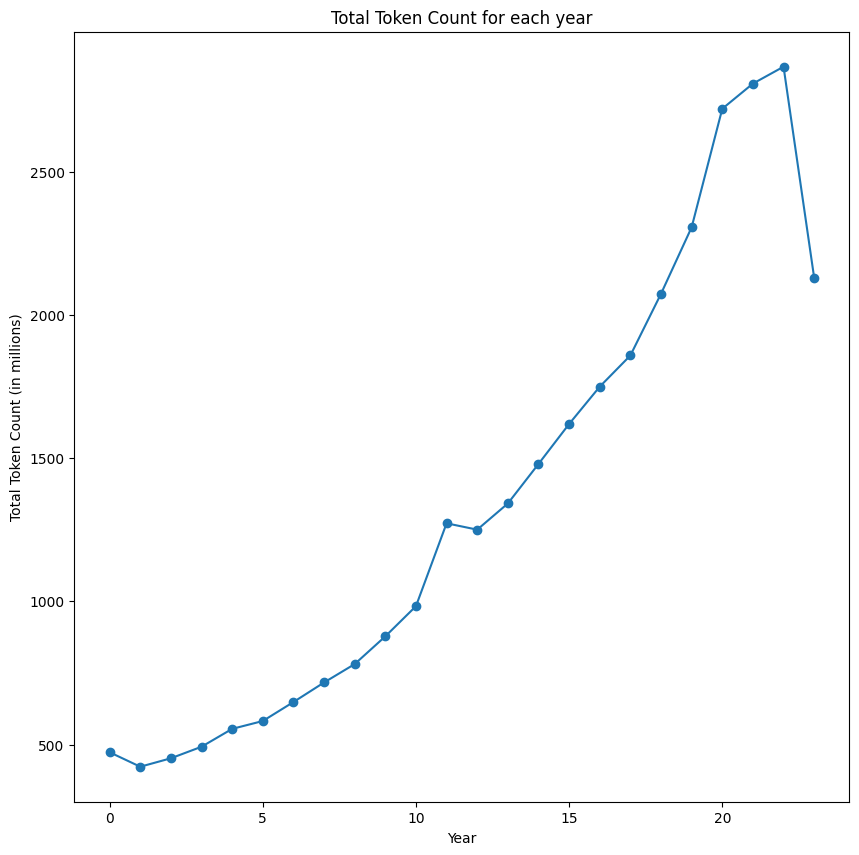

In [255]:
# plot total token count for each year
lst = []
for i in range(24):
    lst.append(total_token_count(year=i))

#plot
import matplotlib.pyplot as plt
plt.plot(lst, 'o-')
# reduce the size of the plot
plt.rcParams['figure.figsize'] = [10, 10]
plt.xlabel('Year')
plt.ylabel('Total Token Count (in millions)')
plt.title('Total Token Count for each year')
plt.show()


# number of tokens in n% papers from each year

count the number of tokens in 2% papers selected randomly from each year after percentile restriction

number of tokens = median * 0.02 * number of papers in that year

### 2% papers from each year

In [256]:
import pandas as pd
total_token_per_year_2percent = []
for i in range(24):
    i_ = f"{i}"
    if i < 10:
        i_ = f"0{i}"
    df_ = pd.read_csv(f"processed_data_level_2/tc_{i_}.csv", usecols=['Token Count'])
    total_token_per_year_2percent.append((f'{0.02 * df_.shape[0] * df_.median().values[0] *1e-6:.2f}',f'{0.02 * df_.shape[0] * df_.mean().values[0] *1e-6:.2f}'))
print("In millions Mean-Median")
total_token_per_year_2percent



In millions Mean-Median


[('5.34', '9.50'),
 ('5.24', '8.47'),
 ('5.86', '9.07'),
 ('6.51', '9.87'),
 ('7.31', '11.12'),
 ('7.98', '11.66'),
 ('8.89', '13.01'),
 ('9.96', '14.35'),
 ('10.89', '15.66'),
 ('12.30', '17.64'),
 ('13.86', '19.71'),
 ('15.85', '26.73'),
 ('17.77', '25.10'),
 ('19.70', '26.88'),
 ('21.82', '29.67'),
 ('24.27', '32.46'),
 ('26.06', '35.02'),
 ('27.46', '37.19'),
 ('30.65', '41.61'),
 ('33.79', '46.14'),
 ('39.74', '54.59'),
 ('41.15', '56.28'),
 ('41.97', '57.38'),
 ('31.69', '42.66')]

In [257]:
# add all the medians and means from above list
import numpy as np

total_token_per_year_2percent = np.array(total_token_per_year_2percent, dtype=float)
sum(total_token_per_year_2percent[:,0]), sum(total_token_per_year_2percent[:,1])

(466.06, 651.7699999999999)

### 5% papers from each year

In [258]:
import pandas as pd
total_token_per_year_npercent = []
for i in range(24):
    i_ = f"{i}"
    if i < 10:
        i_ = f"0{i}"
    df_ = pd.read_csv(f"processed_data_level_2/tc_{i_}.csv", usecols=['Token Count'])
    total_token_per_year_npercent.append((f'{0.05 * df_.shape[0] * df_.median().values[0] *1e-6:.2f}',f'{0.05 * df_.shape[0] * df_.mean().values[0] *1e-6:.2f}'))

total_token_per_year_npercent = np.array(total_token_per_year_npercent, dtype=float)
sum(total_token_per_year_npercent[:,0]), sum(total_token_per_year_npercent[:,1])



(1165.26, 1629.42)

### 10% papers from each year

In [259]:
import pandas as pd
total_token_per_year_npercent = []
for i in range(24):
    i_ = f"{i}"
    if i < 10:
        i_ = f"0{i}"
    df_ = pd.read_csv(f"processed_data_level_2/tc_{i_}.csv", usecols=['Token Count'])
    total_token_per_year_npercent.append((f'{0.1 * df_.shape[0] * df_.median().values[0] *1e-6:.2f}',f'{0.1 * df_.shape[0] * df_.mean().values[0] *1e-6:.2f}'))

total_token_per_year_npercent = np.array(total_token_per_year_npercent, dtype=float)
sum(total_token_per_year_npercent[:,0]), sum(total_token_per_year_npercent[:,1])



(2330.44, 3258.83)